## Prep

In [1]:
# Import packages
import pandas as pd
import plotly.graph_objects as go
import networkx as nx
from ds_common_utils.aux.io.snowflake_tools import SnowflakeTools
from math import log
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import numpy as np

In [2]:
# Get connection
con = SnowflakeTools().get_snowflake_ctx(
     method = 'token',
    user = '250807',
    role = 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD',
    warehouse = 'INSIGHT_ANALYST_WH'
)
with open('sql/item_association.sql', 'r') as query:
        df = pd.read_sql_query(query.read(), con)

snowflake_tools - 2025-06-30 14:39:27.668761+10:00 - Generating new token with 'INSIGHT_ANALYST_MERCH_DE_GENERAL_PRD' role and 'SESSION:ROLE-ANY' scope...
snowflake_tools - 2025-06-30 14:39:32.490645+10:00 - Saved token with '2025-06-30 18:39:32+10:00' expiry...


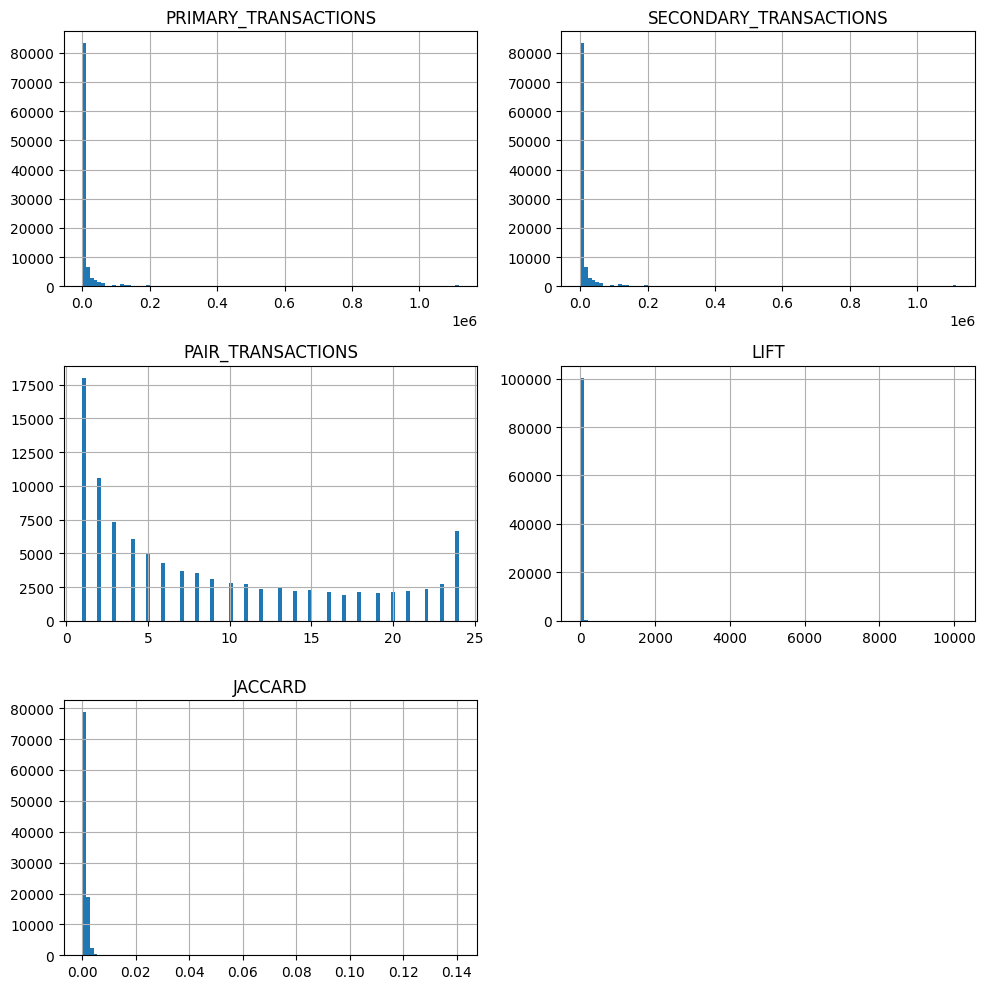

In [3]:
# Plot histograms of numerical columns
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols].hist(bins=100, figsize=(10, 10), layout=(3, 2))
plt.tight_layout()
plt.show()

## Explore

400 Growing media has 1116333 transactions


In [4]:
GM_df = df[(df['PRIMARY_ID'] == '400 GROWING MEDIA') | (df['SECONDARY_ID'] == '400 GROWING MEDIA')]
# GM_df

In [5]:
# Combine both PRIMARY_ID and SECONDARY_ID 
primary_df = GM_df[['PRIMARY_ID', 'PRIMARY_TRANSACTIONS']].rename(
    columns={'PRIMARY_ID': 'sub_dept', 'PRIMARY_TRANSACTIONS': 'transactions'}
)
secondary_df = GM_df[['SECONDARY_ID', 'SECONDARY_TRANSACTIONS']].rename(
    columns={'SECONDARY_ID': 'sub_dept', 'SECONDARY_TRANSACTIONS': 'transactions'}
)

# Concatenate and deduplicate
combined_df = pd.concat([primary_df, secondary_df])
combined_df = combined_df.drop_duplicates(subset=['sub_dept'])
combined_df = combined_df[(combined_df['sub_dept'] != '400 GROWING MEDIA')]

# Group by segment and class, then calculate average transactions
cross_shop_df = combined_df.groupby(['sub_dept'], as_index=False).agg(
    transactions=('transactions', 'max')
)

# Calculate exposure percentage
cross_shop_df['exposure_pct'] = (
    cross_shop_df['transactions'] / 1116333 * 100
)

# Sort result
cross_shop_df = cross_shop_df.sort_values(['transactions'], ascending=False).reset_index(drop=True)

cross_shop_df.head(10)

,sub_dept,transactions,exposure_pct
0,400 VEGETABLES,198080,17.743809
1,400 ANNUAL FLOWERING,137258,12.295435
2,400 FERTILISERS,125259,11.220577
3,401 PLANT SUPPORT,115812,10.374324
4,400 PROPAGATION,114518,10.258409
5,400 FUNCTIONAL POT,91612,8.206512
6,400 PERENNIAL FLOWERING,66584,5.964529
7,400 GARDEN PEST CONTROL,61843,5.539834
8,400 FRUIT AND CITRUS,57350,5.137356
9,400 CLEANING CHEMICALS,53919,4.830010


In [6]:
output_path = 'top_sub_dept_transaction.csv'
cross_shop_df.to_csv(output_path, index=False)

In [7]:
# Extract the top 20 sub-departments by transaction count
top10 = cross_shop_df.nlargest(10, 'transactions').reset_index(drop=True)['sub_dept'].tolist()

## Parameter Tuning

In [22]:
TRX_THRESHOLD = 20 # Min N frequent pairs
QUANTILE = 0.95 # Nth percentile of metric similarity
TOP_N = 1 # top-N associated item classes per primary class
RESO = 1 # >1.0 → more, smaller communities
METRIC = 'LIFT' # LIFT or JACCARD

## Working

In [23]:
# filtered_df = df[(df['PRIMARY_ID'] != '400 GROWING MEDIA' ) & ( df['SECONDARY_ID']!='400 GROWING MEDIA')]

# Filter rows where either primary or secondary is in the top-20 list
filtered_df = df[
    (
        df['PRIMARY_ID'].isin(top10) |
        df['SECONDARY_ID'].isin(top10)
    )
    &
    (df['PRIMARY_ID'] != '400 GROWING MEDIA') &
    (df['SECONDARY_ID'] != '400 GROWING MEDIA')
].reset_index(drop=True)

filtered_df = filtered_df[filtered_df['PAIR_TRANSACTIONS'] >= TRX_THRESHOLD]
threshold = filtered_df[METRIC].quantile(QUANTILE)
filtered_df = filtered_df[filtered_df[METRIC] >= threshold]
top_edges = filtered_df.sort_values(METRIC, ascending=False).groupby('PRIMARY_ID').head(TOP_N)


In [24]:
filtered_df.sort_values(by='PRIMARY_TRANSACTIONS', ascending=False)

,PRIMARY_ID,SECONDARY_ID,PRIMARY_TRANSACTIONS,SECONDARY_TRANSACTIONS,TRX_START_MONTH,TRX_END_MONTH,PAIR_TRANSACTIONS,LIFT,JACCARD
5564,400 VEGETABLES,402 TOOL BAGS AND BELTS,198080,364,2024-06-01,2025-05-01,21,0.325213,0.000106
5495,400 VEGETABLES,401 PET DOORS,198080,338,2024-06-01,2025-05-01,20,0.333552,0.000101
39,400 ANNUAL FLOWERING,400 BUDGET PAINT,137258,504,2024-06-01,2025-05-01,23,0.371236,0.000167
154,400 ANNUAL FLOWERING,400 MOWER ACCESSORIES,137258,502,2024-06-01,2025-05-01,20,0.324100,0.000145
180,400 ANNUAL FLOWERING,400 PAVING PAINT,137258,423,2024-06-01,2025-05-01,20,0.384629,0.000145
187,400 ANNUAL FLOWERING,400 PLANTS OFF RANGE,137258,526,2024-06-01,2025-05-01,21,0.324778,0.000152
276,400 ANNUAL FLOWERING,401 DOOR CHIMES AND SENSORS,137258,529,2024-06-01,2025-05-01,20,0.307558,0.000145
345,400 ANNUAL FLOWERING,402 APPLIANCES,137258,451,2024-06-01,2025-05-01,20,0.360750,0.000145
380,400 ANNUAL FLOWERING,402 TOOL BAGS AND BELTS,137258,364,2024-06-01,2025-05-01,20,0.446973,0.000145
393,400 ANNUAL FLOWERING,403 INDOOR BLINDS,137258,518,2024-06-01,2025-05-01,20,0.314089,0.000145


In [25]:
mode='lines',
line_shape='spline'
    
# Build node size map from your DataFrame
node_size_map = dict(zip(top_edges['PRIMARY_ID'], top_edges['PRIMARY_TRANSACTIONS']))

# Convert values to NumPy array
sizes = np.array(list(node_size_map.values()))

# Use np.ptp instead of .ptp()
norm_sizes = (sizes - sizes.min()) / np.ptp(sizes)  # scale to 0–1
scaled_sizes = 10 + norm_sizes * 30                 # scale to 10–40

# Final size map: Product ID → Scaled Size
scaled_size_map = dict(zip(node_size_map.keys(), scaled_sizes))

# Step 1: Build the full graph
G = nx.Graph()
for _, row in top_edges.iterrows():
    G.add_edge(row['PRIMARY_ID'], row['SECONDARY_ID'], weight=row[METRIC])

# Step 2: Louvain community detection
partition = community_louvain.best_partition(G, weight=METRIC, resolution=RESO)

# Step 3: Layout
pos = nx.spring_layout(G, weight='weight', seed=42
                      )

# Step 4: Edge trace (no filter on weight)
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Step 5: Node trace with Louvain cluster coloring
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']  # Extend if you expect >10 clusters

node_x, node_y, node_color, node_size, hover_text = [], [], [], [], []

for node in G.nodes():
    x, y = pos[node]
    cluster = partition[node]
    size = scaled_size_map.get(node, 10)  # default to small if missing

    node_x.append(x)
    node_y.append(y)
    node_color.append(color_list[cluster % len(color_list)])
    node_size.append(size)
    hover_text.append(f"Product ID: {node}<br>Cluster: {cluster}<br>Transactions: {int(size)}")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    hoverinfo='text',
    text=[str(node) for node in G.nodes()],
    textposition='top center',
    marker=dict(
        color=node_color,
        size=node_size,  # <--- size now dynamic!
        line=dict(width=2, color='black')
    ),
    textfont=dict(
    size=16,          # increase for visibility
    color='black',
    family='Arial'
)
)
# Step 6: Plot
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        width=1200,          # increase width
    height=800, 
        title=dict(text='Louvain Product Clustering (All Edges)', x=0.5, font=dict(size=16)),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=40),
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

## Results

In [26]:
fig.show()

In [27]:
# Merge community partition info with filtered edges
partition_df = pd.DataFrame.from_dict(partition, orient='index', columns=['segment']).reset_index()
partition_df.rename(columns={'index': 'PRIMARY_ID'}, inplace=True)

# Merge and deduplicate
labelled_df = filtered_df.merge(partition_df, on='PRIMARY_ID', how='left')
labelled_df = labelled_df[['PRIMARY_ID', 'SECONDARY_ID', 'PRIMARY_TRANSACTIONS', 'SECONDARY_TRANSACTIONS', 'PAIR_TRANSACTIONS', METRIC, 'segment']].drop_duplicates()
labelled_df = labelled_df.sort_values(by=['segment', METRIC]).reset_index(drop=True)

# Expand display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [28]:
# display(labelled_df)

In [29]:
output_path = 'segment_pair_all.csv'
labelled_df.to_csv(output_path, index=False)

In [30]:
# Combine both PRIMARY_ID and SECONDARY_ID with associated segment
primary_df = labelled_df[['segment', 'PRIMARY_ID', 'PRIMARY_TRANSACTIONS']].rename(
    columns={'PRIMARY_ID': 'sub_dept', 'PRIMARY_TRANSACTIONS': 'transactions'}
)
secondary_df = labelled_df[['segment', 'SECONDARY_ID', 'SECONDARY_TRANSACTIONS']].rename(
    columns={'SECONDARY_ID': 'sub_dept', 'SECONDARY_TRANSACTIONS': 'transactions'}
)

# Concatenate and deduplicate
combined_df = pd.concat([primary_df, secondary_df])
combined_df = combined_df.drop_duplicates(subset=['segment', 'sub_dept'])

# Group by segment and class, then calculate average transactions
exposure_df = combined_df.groupby(['segment', 'sub_dept'], as_index=False).agg(
    transactions=('transactions', 'max')
)

# Calculate exposure percentage
exposure_df['exposure_pct'] = (
    exposure_df['transactions'] / 1116333 * 100
)

# Rename for final output
exposure_df = exposure_df.rename(columns={'segment': 'cluster'})

# Sort result
exposure_df = exposure_df.sort_values(['cluster', 'transactions'], ascending=False).reset_index(drop=True)

# exposure_df

In [31]:
output_path = 'segment_exposure_all.csv'
exposure_df.to_csv(output_path, index=False)

## Regroup segments

In [32]:
# New merged super-segments
merged_mapping = {
    0: 'Noise & Irrelevant',                # cleaning-chemicals noise cluster
    1: 'Exotics & Specimen Fruit',          # fruit, off-range & tropical accents
    2: 'Propagation & Container Systems',   # propagation benches & pots
    3: 'Flowering Displays',                # perennials
    4: 'Flowering Displays',                # annuals
    5: 'Propagation & Container Systems',   # functional pots, auto-tools, vacs
    6: 'Nutrients & Feeding Systems',       # fertilisers & plant support
    7: 'Edible Gardens & Pest Care',        # vegetables & pest controls
    8: 'Edible Gardens & Pest Care',        # pest-control cluster
}

# Build regroup_df from exposure_df
regroup_df = exposure_df.copy()

# Map clusters to your merged super-segments
regroup_df['Macro-segment'] = regroup_df['cluster'].map(merged_mapping)

# Select and order the columns you want
regroup_df = regroup_df[
    ['Macro-segment', 'sub_dept', 'transactions', 'exposure_pct']
]

# Sort by Macro-segment and then by exposure_pct descending
regroup_df = regroup_df.sort_values(
    ['Macro-segment', 'exposure_pct'],
    ascending=[True, False]
).reset_index(drop=True)

In [33]:
regroup_df.groupby(['Macro-segment'], as_index=False).agg(TOTAL_TRANSACTIONS=('transactions', 'sum'))

,Macro-segment,TOTAL_TRANSACTIONS
0,Edible Gardens & Pest Care,274905
1,Exotics & Specimen Fruit,203045
2,Flowering Displays,263999
3,Noise & Irrelevant,617672
4,Nutrients & Feeding Systems,697834
5,Propagation & Container Systems,381355


In [37]:
regroup_df

,Macro-segment,sub_dept,transactions,exposure_pct
0,Edible Gardens & Pest Care,400 VEGETABLES,198080,17.743809
1,Edible Gardens & Pest Care,400 GARDEN PEST CONTROL,61843,5.539834
2,Edible Gardens & Pest Care,400 DECKING TIMBER,1380,0.123619
3,Edible Gardens & Pest Care,400 WATER SAVING AGENT,1303,0.116721
4,Edible Gardens & Pest Care,401 SITE MANAGEMENT,1292,0.115736
5,Edible Gardens & Pest Care,400 FUEL CONTAINERS,1271,0.113855
6,Edible Gardens & Pest Care,401 LADDERS,1248,0.111795
7,Edible Gardens & Pest Care,401 METAL SECTIONS,1127,0.100956
8,Edible Gardens & Pest Care,400 GUTTER GUARD,1069,0.095760
9,Edible Gardens & Pest Care,400 BATTERIES AND CHARGERS,1029,0.092177


In [35]:
output_path = 'segment_exposure_all_regrouped.csv'
regroup_df.to_csv(output_path, index=False)

## Intepretation

**Edible Gardens & Pest Care**

Combinations of Vegetables and Garden Pest Control reflect commercial food-crop installations and upkeep—landscape teams installing vegetable beds pick up bulk soil along with insecticides, fungicides and rodent baits to protect their new plantings.

**Nutrients & Feeding Systems**

The pairing of Fertilisers with Plant Support (stakes, ties, feeding trays) signals projects where soil amendments and the tools to apply or support those feeds are bought together—think nursery or landscape crews mixing in fertilizer and installing support structures in one go.

**Propagation & Container Systems**

Propagation trays and Functional Pots show the “bench-to-pot” workflow: commercial growers order soil and the containers they’ll pot on seedlings or cuttings into, often alongside bench vacs, potting benches and auto-tools for high-throughput propagation.

**Flowering Displays**

Clusters of Annual and Perennial Flowering plants point to high-impact bedding and border installations—retail or hospitality clients buying flowering media plus the seasonal or long-term blooms needed for showpiece planters, hanging baskets and display beds.

**Exotics & Specimen Fruit**

Groupings around Fruit & Citrus and Special-Order Plants Off Range identify feature plantings of rare or premium specimens—fruit trees, exotic foliage or seasonal accents that require both growing media and bespoke ordering.

**Noise & Irrelevant**

Any associations with Cleaning Chemicals fall into this bucket—maintenance or housekeeping by-products that have no direct relevance to commercial planting projects and should be excluded from strategic analyses.

#